In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import numpy as np


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Helper function to load model and tokenizer
def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    return model, tokenizer

# Load each model and tokenizer
bert_model, bert_tokenizer = load_model_and_tokenizer("harshal-11/DistillBERT-Political-Finetune")
roberta_model, roberta_tokenizer = load_model_and_tokenizer("harshal-11/roberta-political-bias")
distilbert_model, distilbert_tokenizer = load_model_and_tokenizer("harshal-11/DistillBERT-Political-Finetune")
ernie_model, ernie_tokenizer = load_model_and_tokenizer("harshal-11/Ernie-PoliticalBias-Finetune")


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# Example test data loading (replace with your actual data loading method)
test_df = pd.read_csv("test.csv")
# Function to prepare data for the model



KeyError: 'text'

In [6]:
test_df =  test_df.drop(columns=['title_length'])


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [10]:
from sklearn.preprocessing import LabelEncoder

print(test_df['label'].dtype)  # Check the dtype of the labels

# If labels are non-numeric, use LabelEncoder to convert them to numeric
if test_df['label'].dtype == object:
    encoder = LabelEncoder()
    test_df['label'] = encoder.fit_transform(test_df['label'])
    print("Labels converted to integers.")

object
Labels converted to integers.


In [12]:
def prepare_data(df, tokenizer):
    encodings = tokenizer(df['title'].tolist(), truncation=True, padding=True, max_length=256, return_tensors="pt")
    labels = torch.tensor(df['label'].values)
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    return DataLoader(dataset, batch_size=16)

# Prepare data loaders for each model
bert_loader = prepare_data(test_df, bert_tokenizer)
roberta_loader = prepare_data(test_df, roberta_tokenizer)
distilbert_loader = prepare_data(test_df, distilbert_tokenizer)
ernie_loader = prepare_data(test_df, ernie_tokenizer)

In [13]:
def evaluate_model(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds, all_probs

# Evaluate each model
bert_labels, bert_preds, bert_probs = evaluate_model(bert_model, bert_loader)
roberta_labels, roberta_preds, roberta_probs = evaluate_model(roberta_model, roberta_loader)
distilbert_labels, distilbert_preds, distilbert_probs = evaluate_model(distilbert_model, distilbert_loader)
ernie_labels, ernie_preds, ernie_probs = evaluate_model(ernie_model, ernie_loader)


In [18]:
# def plot_roc_curve(labels, probs, model_name):
#     fpr, tpr, thresholds = roc_curve(labels, probs[:, 1])
#     roc_auc = auc(fpr, tpr)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
#     plt.legend(loc="lower right")
#     plt.show()

# # Plot ROC Curves
# plot_roc_curve(bert_labels, np.array(bert_probs), "BERT")
# plot_roc_curve(roberta_labels, np.array(roberta_probs), "RoBERTa")
# plot_roc_curve(distilbert_labels, np.array(distilbert_probs), "DistilBERT")
# plot_roc_curve(ernie_labels, np.array(ernie_probs), "ERNIE")


In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc_curve(labels, probs, class_names, model_name):
    # Binarize labels in a one-vs-all fashion
    binarized_labels = label_binarize(labels, classes=[i for i in range(len(class_names))])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Example of using this function with a model's output
# Assuming `class_names` is a list of your class names and `model_probs` are the output probabilities from the model
class_names = ['LeftWing', 'Neutral', 'RightWing']
# Example usage, replace `bert_labels` and `bert_probs` with actual labels and probabilities from your model
# plot_multiclass_roc_curve(bert_labels, np.array(bert_probs), class_names, "BERT")


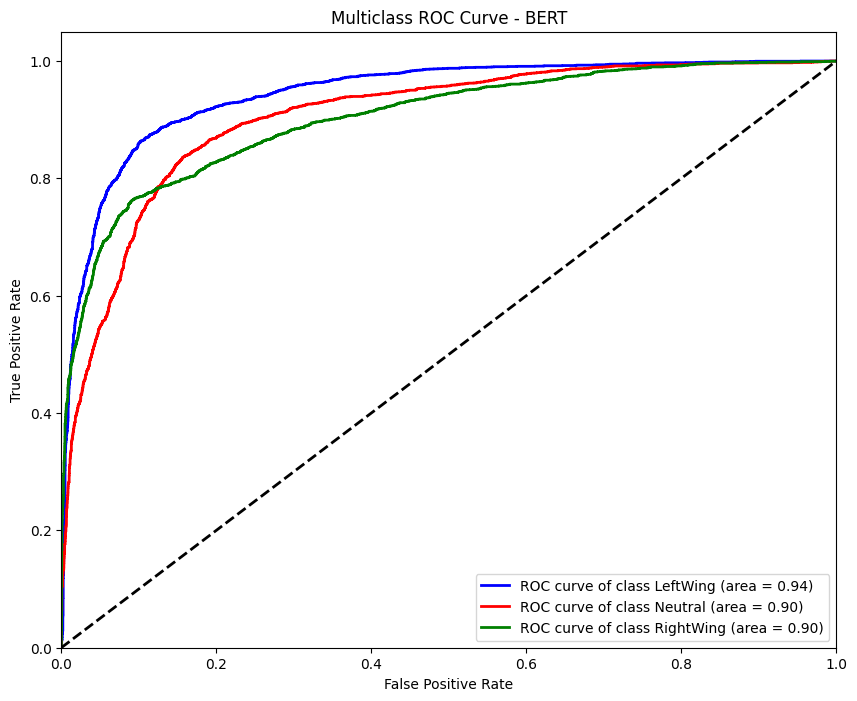

In [16]:
# Assuming `bert_labels` and `bert_probs` are obtained from evaluating the BERT model
plot_multiclass_roc_curve(bert_labels, np.array(bert_probs), class_names, "BERT")


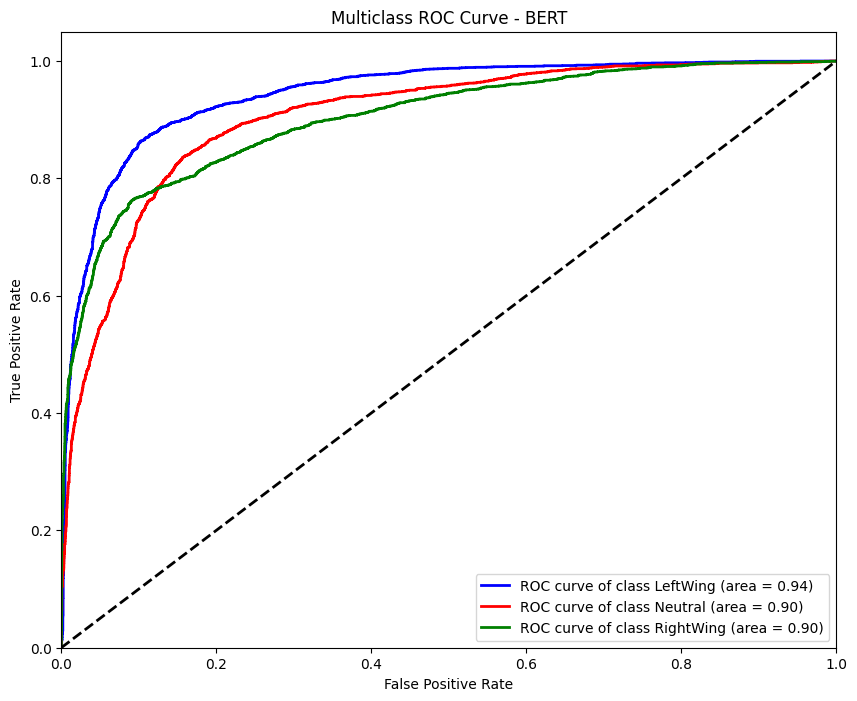

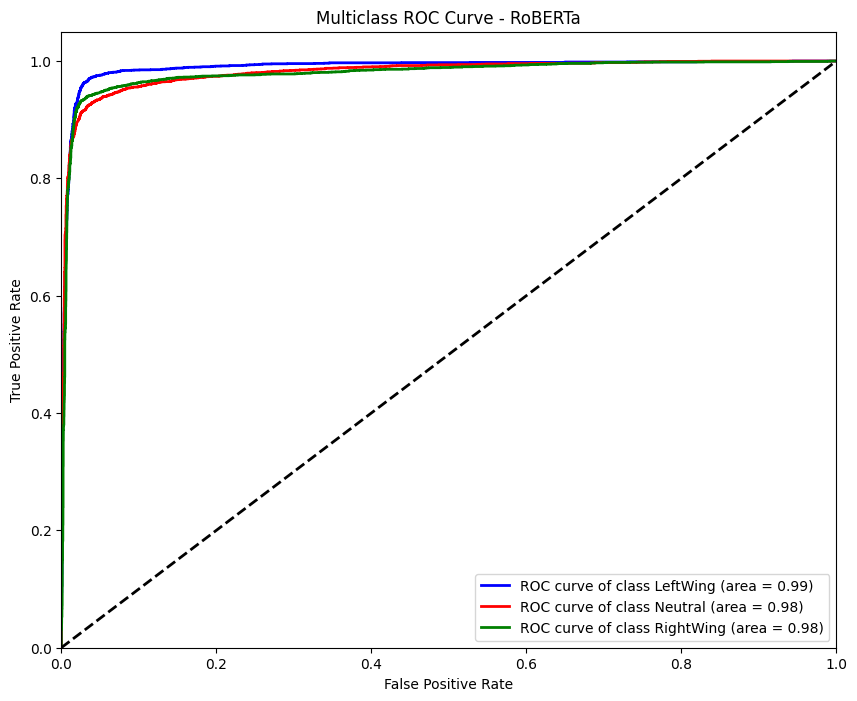

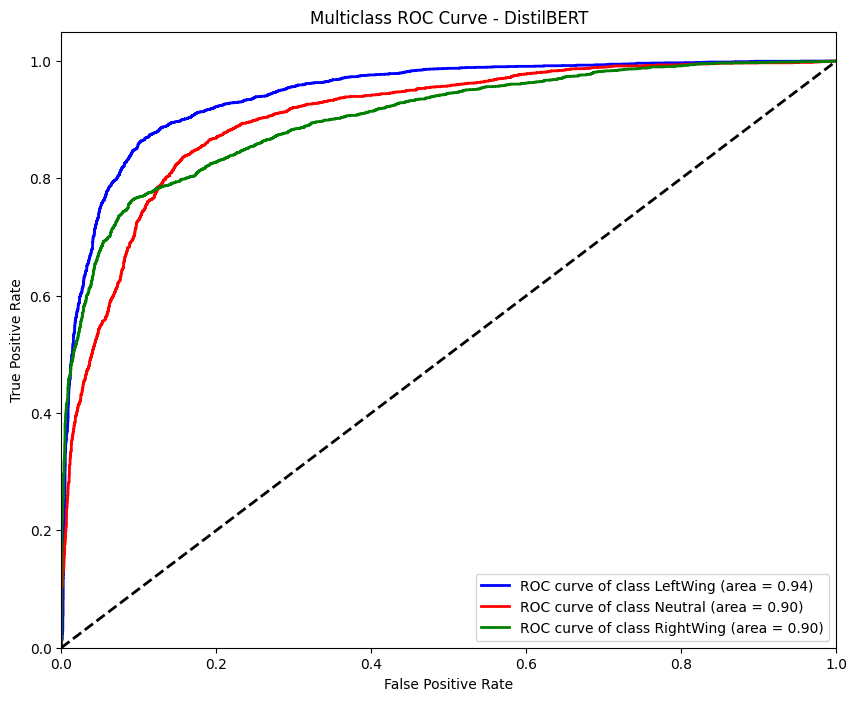

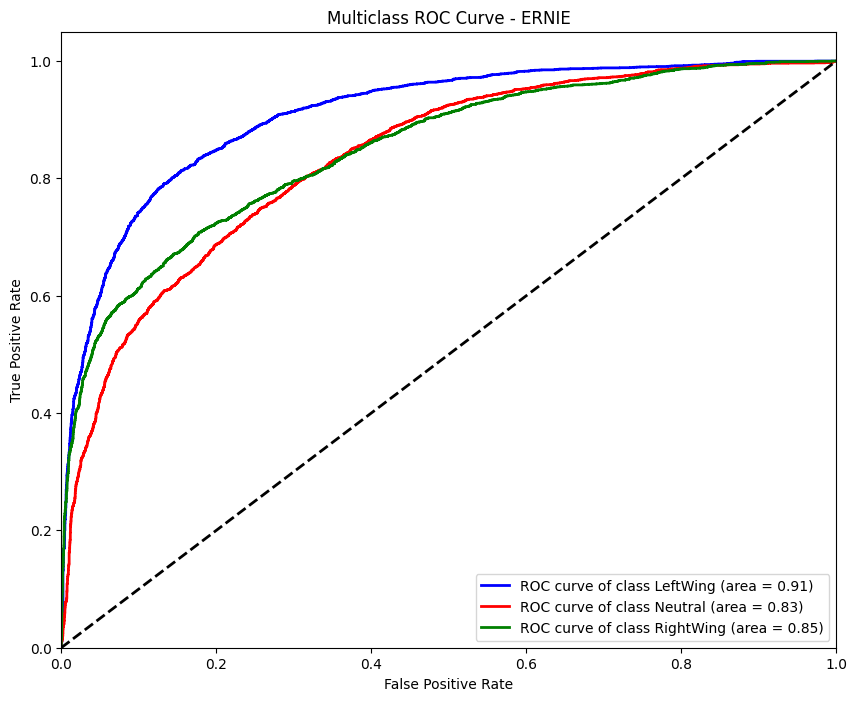

In [19]:
# Class names - adjust according to your labels
class_names = ['LeftWing', 'Neutral', 'RightWing']

# Plot ROC Curve for BERT
plot_multiclass_roc_curve(bert_labels, np.array(bert_probs), class_names, "BERT")

# Plot ROC Curve for RoBERTa
plot_multiclass_roc_curve(roberta_labels, np.array(roberta_probs), class_names, "RoBERTa")

# Plot ROC Curve for DistilBERT
plot_multiclass_roc_curve(distilbert_labels, np.array(distilbert_probs), class_names, "DistilBERT")

# Plot ROC Curve for ERNIE
plot_multiclass_roc_curve(ernie_labels, np.array(ernie_probs), class_names, "ERNIE")


In [21]:
pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


In [23]:
def plot_confusion_matrix(actual_labels, predicted_labels, class_names, model_name):
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


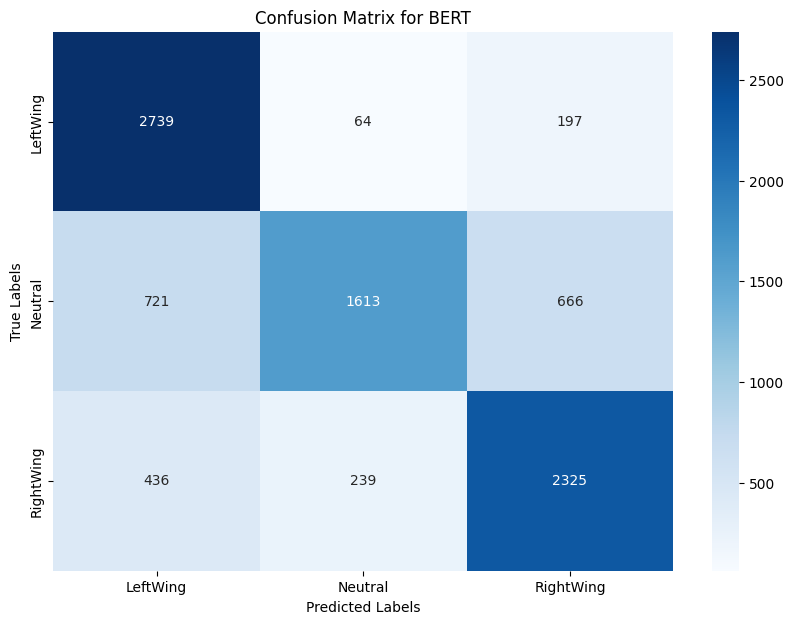

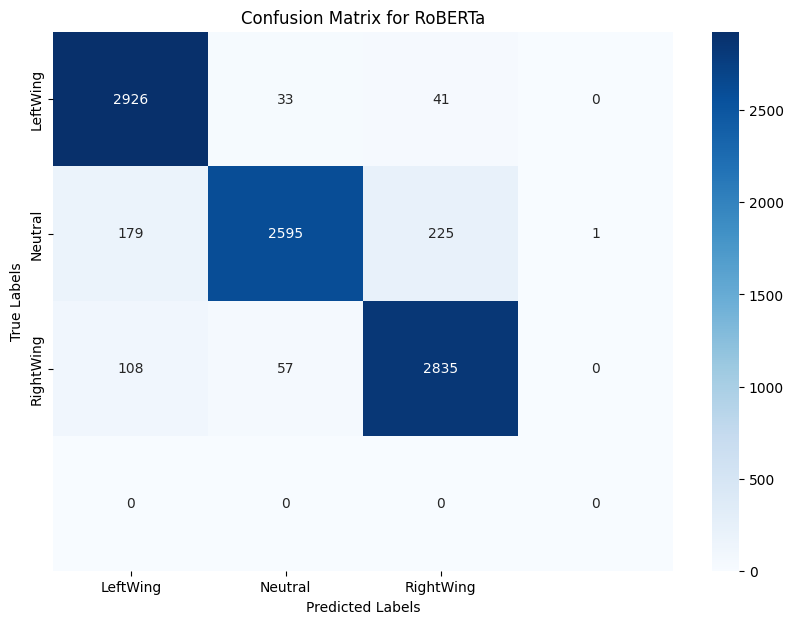

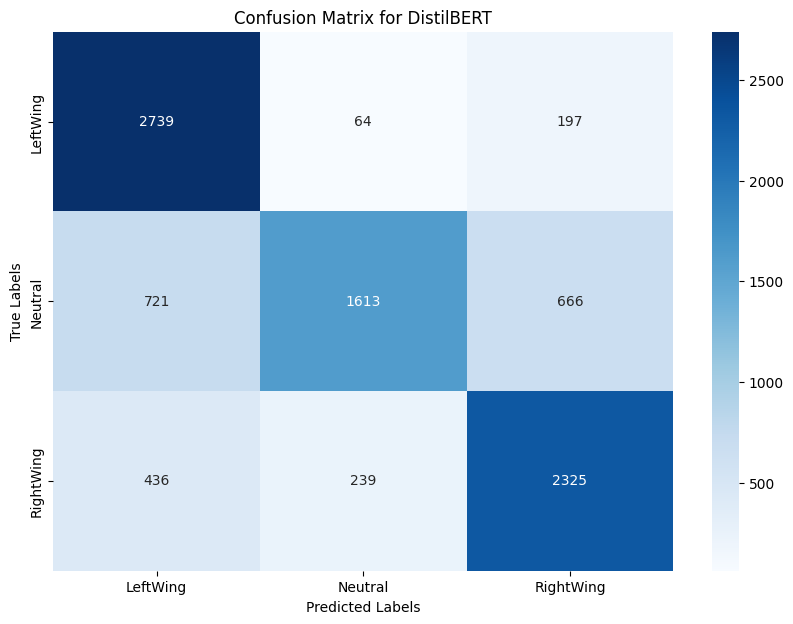

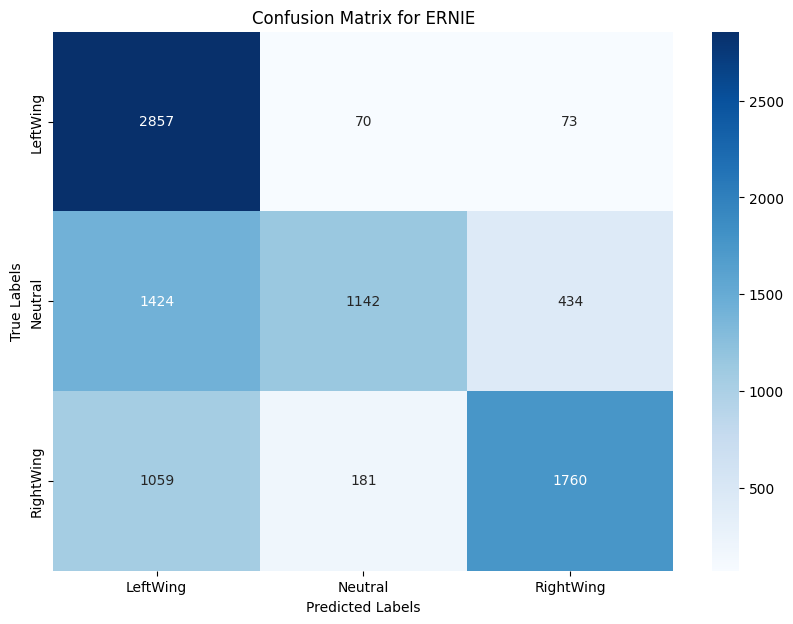

In [24]:
# Assuming class names are defined as follows
class_names = ['LeftWing', 'Neutral', 'RightWing']

# Plot Confusion Matrix for BERT
plot_confusion_matrix(bert_labels, bert_preds, class_names, "BERT")

# Plot Confusion Matrix for RoBERTa
plot_confusion_matrix(roberta_labels, roberta_preds, class_names, "RoBERTa")

# Plot Confusion Matrix for DistilBERT
plot_confusion_matrix(distilbert_labels, distilbert_preds, class_names, "DistilBERT")

# Plot Confusion Matrix for ERNIE
plot_confusion_matrix(ernie_labels, ernie_preds, class_names, "ERNIE")


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [32]:
def calculate_metrics(true_labels, predicted_labels, average_type='weighted'):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average=average_type)
    recall = recall_score(true_labels, predicted_labels, average=average_type)
    f1 = f1_score(true_labels, predicted_labels, average=average_type)
    
    return accuracy, precision, recall, f1


In [33]:
# Calculate and print metrics for BERT
bert_accuracy, bert_precision, bert_recall, bert_f1 = calculate_metrics(bert_labels, bert_preds)
print(f"BERT Metrics:\nAccuracy: {bert_accuracy:.4f}, Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, F1 Score: {bert_f1:.4f}")

# Calculate and print metrics for RoBERTa
roberta_accuracy, roberta_precision, roberta_recall, roberta_f1 = calculate_metrics(roberta_labels, roberta_preds)
print(f"RoBERTa Metrics:\nAccuracy: {roberta_accuracy:.4f}, Precision: {roberta_precision:.4f}, Recall: {roberta_recall:.4f}, F1 Score: {roberta_f1:.4f}")

# Calculate and print metrics for DistilBERT
distilbert_accuracy, distilbert_precision, distilbert_recall, distilbert_f1 = calculate_metrics(distilbert_labels, distilbert_preds)
print(f"DistilBERT Metrics:\nAccuracy: {distilbert_accuracy:.4f}, Precision: {distilbert_precision:.4f}, Recall: {distilbert_recall:.4f}, F1 Score: {distilbert_f1:.4f}")

# Calculate and print metrics for ERNIE
ernie_accuracy, ernie_precision, ernie_recall, ernie_f1 = calculate_metrics(ernie_labels, ernie_preds)
print(f"ERNIE Metrics:\nAccuracy: {ernie_accuracy:.4f}, Precision: {ernie_precision:.4f}, Recall: {ernie_recall:.4f}, F1 Score: {ernie_f1:.4f}")


BERT Metrics:
Accuracy: 0.7419, Precision: 0.7581, Recall: 0.7419, F1 Score: 0.7340
RoBERTa Metrics:
Accuracy: 0.9284, Precision: 0.9305, Recall: 0.9284, F1 Score: 0.9281
DistilBERT Metrics:
Accuracy: 0.7419, Precision: 0.7581, Recall: 0.7419, F1 Score: 0.7340
ERNIE Metrics:
Accuracy: 0.6399, Precision: 0.7104, Recall: 0.6399, F1 Score: 0.6245


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


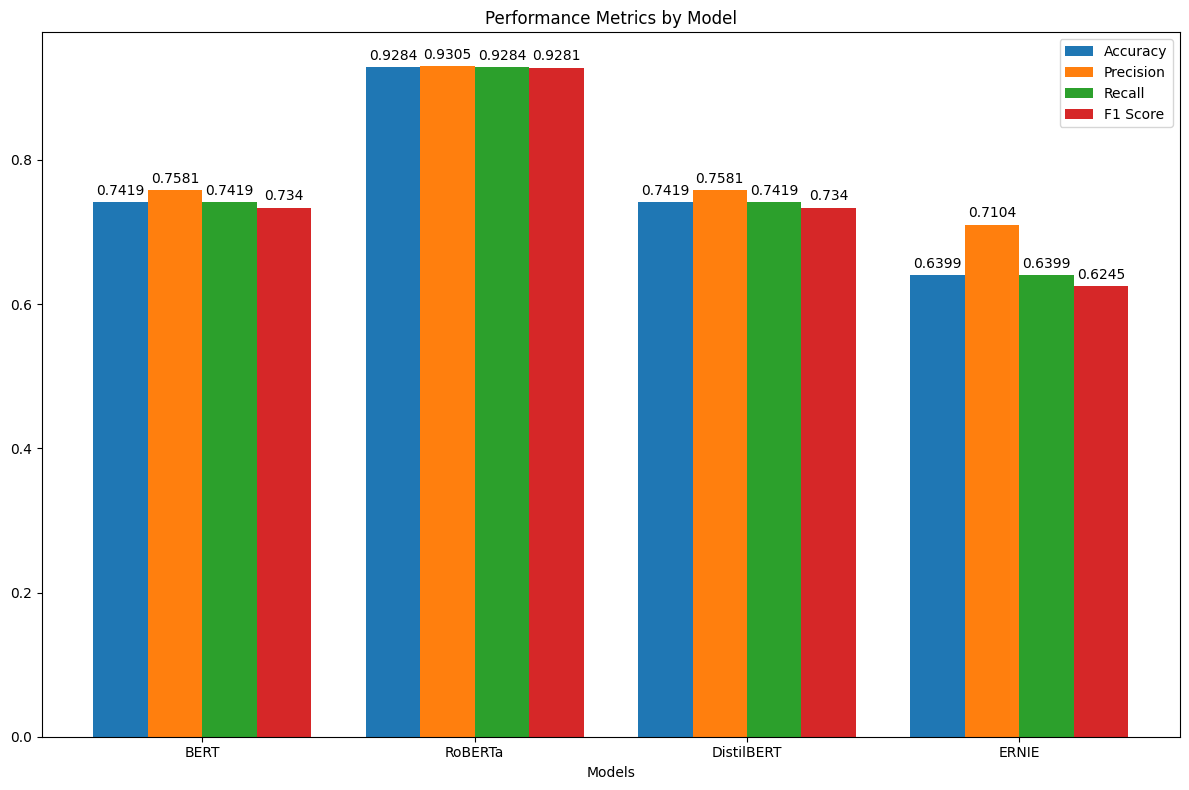

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your results
models = ['BERT', 'RoBERTa', 'DistilBERT', 'ERNIE']
accuracies = [0.7419, 0.9284, 0.7419, 0.6399]
precisions = [0.7581, 0.9305, 0.7581, 0.7104]
recalls = [0.7419, 0.9284, 0.7419, 0.6399]
f1_scores = [0.7340, 0.9281, 0.7340, 0.6245]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width*1.5, accuracies, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precisions, width, label='Precision')
rects3 = ax.bar(x + width/2, recalls, width, label='Recall')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()
plt.show()


In [36]:
import pandas as pd

# Assuming `test_df` is your original DataFrame and it includes 'text' and 'true_label'
# Also assuming that `bert_preds`, `roberta_preds`, `distilbert_preds`, `ernie_preds` are available as lists or numpy arrays

# Create a new DataFrame
results_df = pd.DataFrame({
    'Text': test_df['title'],
    'True Label': test_df['label'],
    'BERT Predicted Label': bert_preds,
    'RoBERTa Predicted Label': roberta_preds,
    'DistilBERT Predicted Label': distilbert_preds,
    'ERNIE Predicted Label': ernie_preds
})

# If the original labels were encoded (e.g., LabelEncoder), and you want to map them back to original categorical labels:
# encoder.inverse_transform can be used if `encoder` is your LabelEncoder instance that was used to transform labels
# results_df['True Label'] = encoder.inverse_transform(results_df['True Label'])
# Similarly, apply inverse_transform for each predicted label column if necessary

# Display the DataFrame
print(results_df.head())


                                                Text  True Label  \
0  MAIN POINTS THE OBJECTIVISTS / ARI HAVE MISSED...           2   
1  Art of peace. How to live peacefully without c...           2   
2  Victor Hugo kicked Shakespeare's ass You may r...           2   
3  Can Turning Countries into Joint Stock Compani...           2   
4  Debunking myths about the US embargo on Cuba. ...           2   

   BERT Predicted Label  RoBERTa Predicted Label  DistilBERT Predicted Label  \
0                     2                        2                           2   
1                     2                        2                           2   
2                     2                        2                           2   
3                     0                        2                           0   
4                     2                        2                           2   

   ERNIE Predicted Label  
0                      2  
1                      0  
2                      0  
3 

In [38]:
results_df

,Text,True Label,BERT Predicted Label,RoBERTa Predicted Label,DistilBERT Predicted Label,ERNIE Predicted Label
0,MAIN POINTS THE OBJECTIVISTS / ARI HAVE MISSED...,2,2,2,2,2
1,Art of peace. How to live peacefully without c...,2,2,2,2,0
2,Victor Hugo kicked Shakespeare's ass You may r...,2,2,2,2,0
3,Can Turning Countries into Joint Stock Compani...,2,0,2,0,0
4,Debunking myths about the US embargo on Cuba. ...,2,2,2,2,0
...,...,...,...,...,...,...
8995,RIP Pupper,1,2,1,2,0
8996,Um.....lol,1,2,1,2,0
8997,Biden Knew,1,2,1,2,2
8998,Dumb puck,1,1,1,1,2


In [39]:
# Save to CSV
results_df.to_csv("model_comparison_results.csv", index=False)
